In [1]:
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm

%matplotlib inline

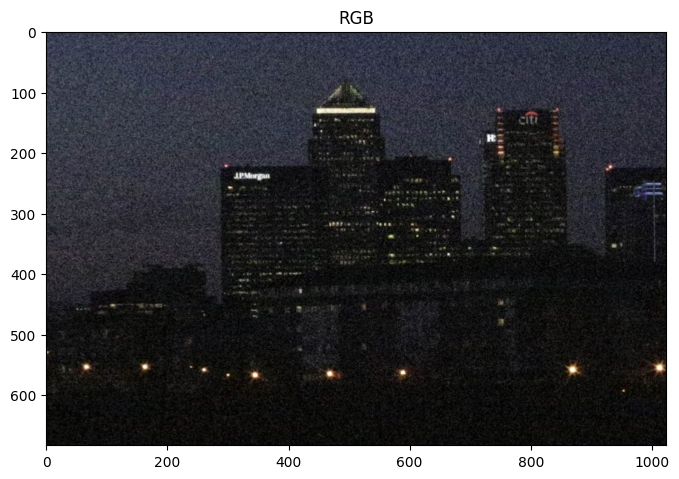

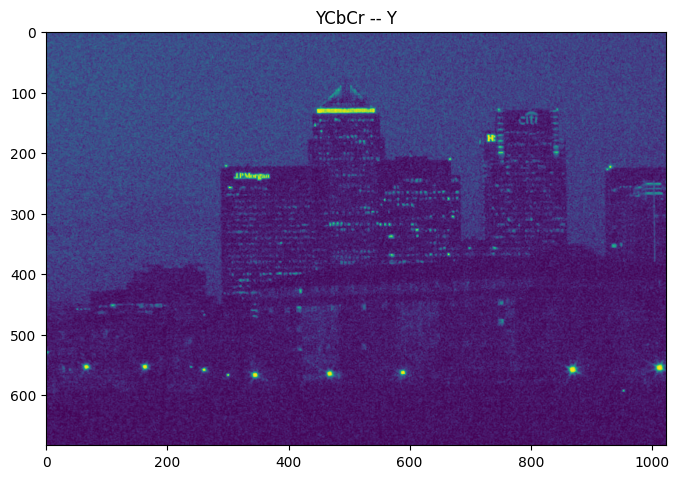

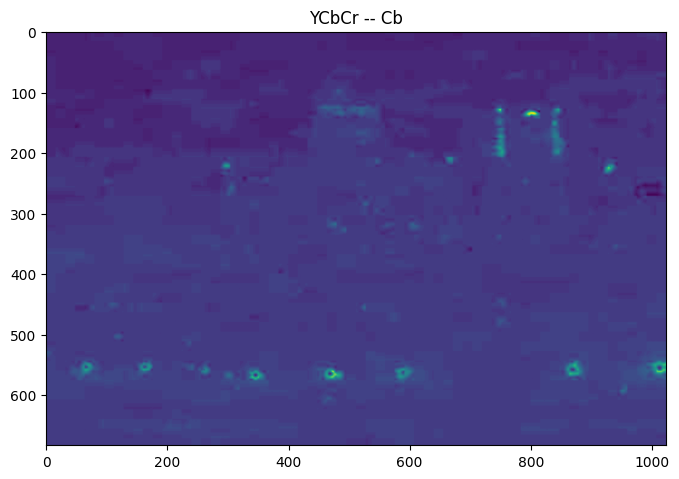

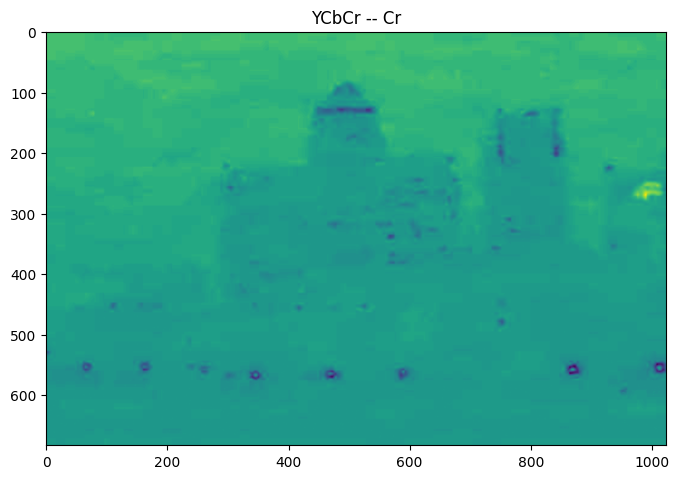

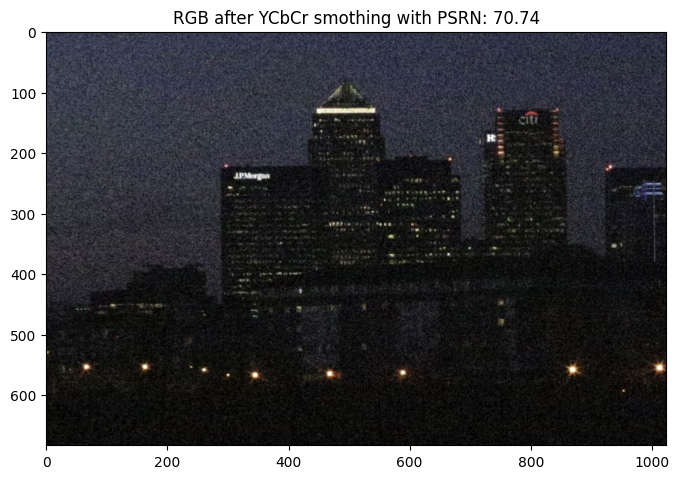

In [2]:
image_path = '/home/alexey/Downloads/iso_noisy_image.jpeg'
img = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.title('RGB')
plt.imshow(img)

ycbcr_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

# for ch_to_blur in [1, 2]:
#     ycbcr_image[ch_to_blur] = cv2.GaussianBlur(ycbcr_image[ch_to_blur], (5, 5), 1)

for i, channel in zip([0, 1, 2], ['Y', 'Cb', 'Cr']):
    plt.figure(figsize=(8, 6))
    plt.title('YCbCr -- {}'.format(channel))
    plt.imshow(ycbcr_image[..., i])
    
smoothed_rgb = cv2.cvtColor(ycbcr_image, cv2.COLOR_YCrCb2RGB)

plt.figure(figsize=(8, 6))
plt.title('RGB after YCbCr smothing with PSRN: {:.2f}'.format(cv2.PSNR(img, smoothed_rgb)))
plt.imshow(smoothed_rgb)

plt.show()

In [3]:
light_channel = ycbcr_image[..., 0].copy()

In [7]:
def generate_batt(size=(5, 5), d0=5, n=2):
    kernel = np.fromfunction(
        lambda x, y: \
            1 / (1 + (((x - size[0] // 2) ** 2 + (
                    y - size[1] // 2) ** 2) ** 1 / 2) / d0) ** n,
        (size[0], size[1])
    ).astype(np.float32)
    return kernel


def custom_softmax(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(x))


def custom_swish(x: torch.Tensor) -> torch.Tensor:
    return x * torch.tanh(x)


def real_imaginary_relu(z):
    return nn.functional.relu(z.real) + 1.j * nn.functional.relu(z.imag)


def phase_amplitude_relu(z):
    return nn.functional.relu(torch.abs(z)) * torch.exp(1.j * torch.angle(z))


def real_imaginary_swish(z):
    return nn.functional.silu(z.real) + 1.j * nn.functional.silu(z.imag)


def phase_amplitude_swish(z):
    return nn.functional.silu(torch.abs(z)) * torch.exp(1.j * torch.angle(z))


class LowFrequencyImageComponent(nn.Module):
    def __init__(self, shape, four_normalized=True):
        super().__init__()

        self.four_normalized = 'ortho' if four_normalized else None
        self.kernel = generate_batt(shape, 5000, 5)
        
        self.image_shape = shape

        self.kernel[:self.kernel.shape[0] // 2] = \
            np.flip(self.kernel[:self.kernel.shape[0] // 2], 0)
        self.kernel[self.kernel.shape[0] // 2:] = \
            np.flip(self.kernel[self.kernel.shape[0] // 2:], 0)

        self.kernel = nn.Parameter(torch.from_numpy(self.kernel))
        
        self.conv1_w = nn.Parameter(torch.randn(3, 1, 5, 5).to(torch.cfloat))
        self.conv1_b = nn.Parameter(torch.randn(3).to(torch.cfloat))
        
        self.conv2_w = nn.Parameter(torch.randn(1, 3, 5, 5).to(torch.cfloat))
        self.conv2_b = nn.Parameter(torch.randn(1).to(torch.cfloat))
        
        self.conv3_w = nn.Parameter(torch.randn(1, 1, 1, 1).to(torch.cfloat))
        self.conv3_b = None
        
        self.activation_1 = phase_amplitude_swish
        
    def apply_fft_kernel(self, x):
        return x*self.kernel[:, -x.size(3):]
    
    def parameters(self):
        return [self.conv1_w, self.conv1_b, self.conv2_w, self.conv2_b, self.conv3_w]

    def update_device(self, device):
        if self.device != device:
            self.device = device
            self.kernel = self.kernel.to(device)
            
    def get_raw_image(self, x):
        fourier_transform_x = torch.fft.rfft2(
            x, norm=self.four_normalized
        )
        
        n_fourier_transform_x = self.apply_fft_kernel(
            fourier_transform_x
        ).to(torch.cfloat)
        x_with_low_freq = torch.fft.irfft2(
            n_fourier_transform_x, norm=self.four_normalized
        )

        return x_with_low_freq[:, :, :self.image_shape[0], :self.image_shape[1]]

    def forward(self, x):
        fourier_transform_x = torch.fft.rfft2(
            x, norm=self.four_normalized
        )
        
        n_fourier_transform_x = self.apply_fft_kernel(
            fourier_transform_x
        ).to(torch.cfloat)
        
        x = nn.functional.conv2d(
            fourier_transform_x,
            self.conv1_w,
            self.conv1_b,
            padding=2
        )
        x = self.activation_1(x)
        x = nn.functional.conv2d(
            x,
            self.conv2_w,
            self.conv2_b,
            padding=2
        )
        x = self.activation_1(x)
        x = nn.functional.conv2d(
            x,
            self.conv3_w,
            self.conv3_b,
            padding=0
        )

        restored_x = torch.fft.irfft2(
            x, norm=self.four_normalized
        )

        return restored_x[:, :, :self.image_shape[0], :self.image_shape[1]]

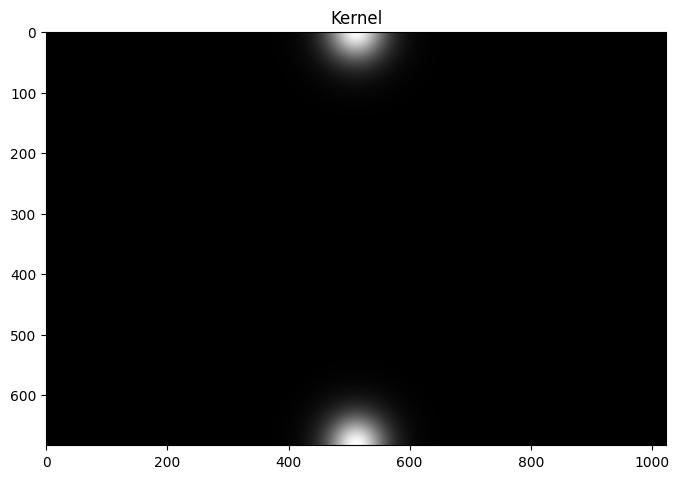

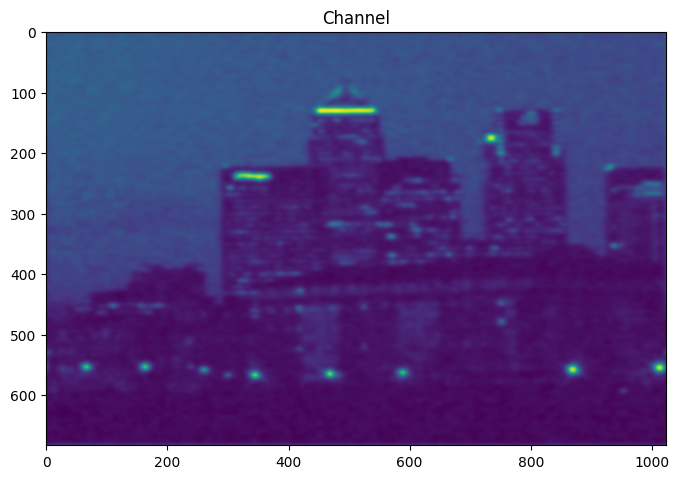

In [12]:
device = 'cuda:0'
torch_tensor = torch.FloatTensor(light_channel).unsqueeze(0).unsqueeze(0).to(device) / 255.0
ll_layer = LowFrequencyImageComponent(shape=light_channel.shape[:2]).to(device)
llf_image = ll_layer.get_raw_image(torch_tensor)

raw_blurred_image = (llf_image.detach().to('cpu').detach().numpy()[0, 0] * 255.0).astype(np.uint8)

plt.figure(figsize=(8, 6))
plt.title('Kernel')
plt.imshow((ll_layer.kernel.detach().to('cpu').numpy() * 255.0).astype(np.uint8), 'gray')

plt.figure(figsize=(8, 6))
plt.title('Channel')
plt.imshow(raw_blurred_image)

plt.show()

In [11]:
optimizer = torch.optim.RAdam(ll_layer.parameters(), lr=0.01)
y = torch_tensor.clone()
x = torch_tensor.clone()
loss_func = nn.MSELoss()

N = 1000
with tqdm(total=N) as pbar:
    for batch_i in range(N):
        optimizer.zero_grad()
        new_y = ll_layer(x)
        loss = loss_func(new_y, y)
        loss.backward()
        optimizer.step()
        
        pbar.postfix = \
        'Loss: {:.5f}'.format(
            loss.item()
        )
        pbar.update(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

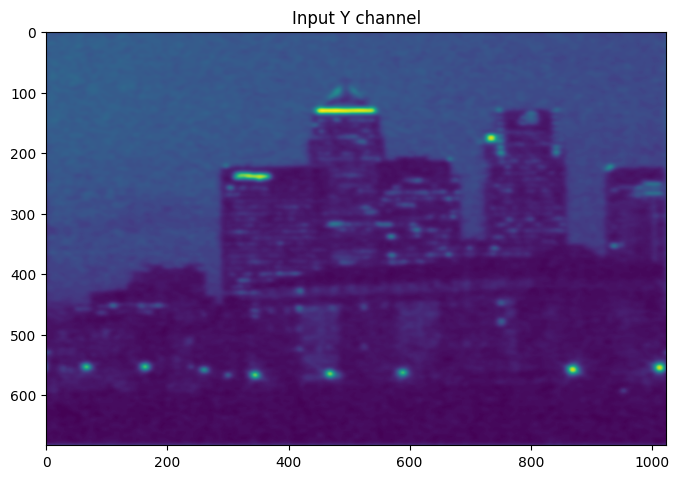

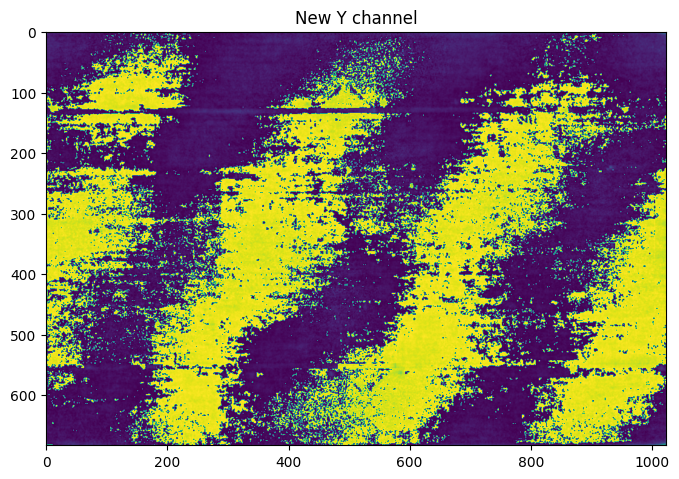

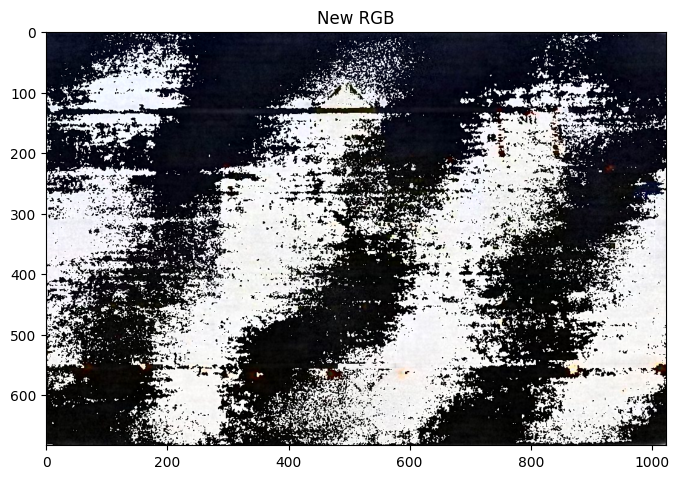

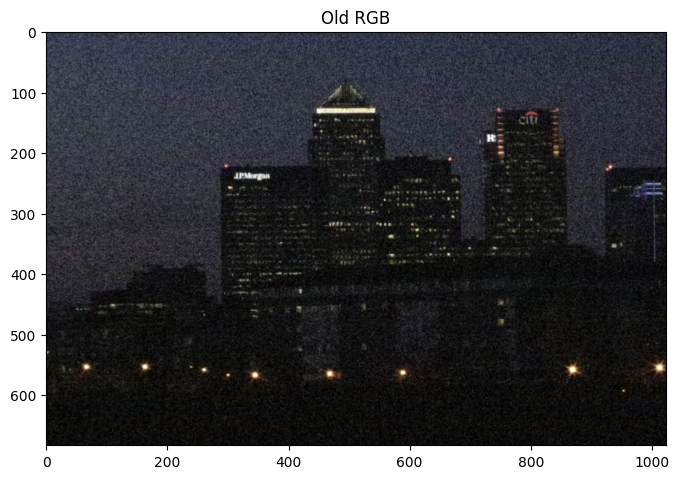

In [47]:
llf_image = ll_layer(torch_tensor)

plt.figure(figsize=(8, 6))
plt.title('Input Y channel')
plt.imshow(raw_blurred_image)

plt.figure(figsize=(8, 6))
plt.title('New Y channel')
plt.imshow((llf_image.detach().numpy()[0, 0] * 255.0).astype(np.uint8))

new_ycbcr_image = ycbcr_image.copy()
new_ycbcr_image[..., 0] = (llf_image.detach().numpy()[0, 0] * 255.0).astype(np.uint8)
new_rgb = cv2.cvtColor(new_ycbcr_image, cv2.COLOR_YCrCb2RGB)

plt.figure(figsize=(8, 6))
plt.title('New RGB')
plt.imshow(new_rgb)

plt.figure(figsize=(8, 6))
plt.title('Old RGB')
plt.imshow(img)

plt.show()